#  spectra holo at AuxTel for configuration A

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- 
- creation date : March 30th  2022



- **kernel anaconda3_auxtel** at CC or **python 3** locally

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

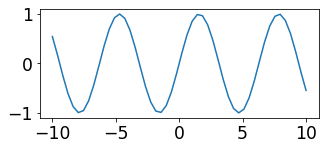

In [3]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [4]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [5]:
from datetime import datetime,date

In [6]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [7]:
string_date

'2022-03-31'

In [8]:
from iminuit import Minuit
import iminuit

In [9]:
iminuit.__version__

'2.2.0'

In [10]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.spectrum import Spectrum, detect_lines
from spectractor.extractor.spectrum import *
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1, ATMOSPHERIC_LINES
from spectractor.config import load_config
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy.interpolate import interp1d

In [11]:
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.007, 0.02],width_bounds=[5, 30])  # libradtran paper fig.3, broad line

In [12]:
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

In [13]:
from time import sleep

In [14]:
from astropy.time import Time
import astropy.units as u

# Function

In [15]:
def file_tag_forsorting(filename):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('^exposure_.*([0-9][0-9][0-9][0-9][0-9])_postisrccd.*', filename)
    if len(m)>0:
        return m[0]
    else:
        return None


In [16]:
def subdir_tag_forsorting(subdir):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('.*([0-9][0-9][0-9][0-9][0-9])$', subdir)
    if len(m)>0:
        return m[0]
    else:
        return None


In [17]:
file_tag_forsorting('exposure_2022031600330_postisrccd.fits')

'00330'

In [18]:
subdir_tag_forsorting('2022031600330')

'00330'

# Config

In [19]:
# path index for each month
DATE="20220316"

In [20]:
version="v5.0"

In [21]:
# Choose the config filename
list_of_spectractorconfigfiles= ["auxtel_configA.ini","auxtel_configB.ini","auxtel_configC.ini","auxtel_configD.ini"]
config_idx = 0
configfilename= list_of_spectractorconfigfiles[config_idx]
configdir = "configA"

# Path

In [22]:
HOSTCC=True

In [23]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2022/holo/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/holo/"+configdir+"/"+DATE)
    
else:
    #path_auxtel="/Users/dagoret/DATA/AuxTelData2021"
    path_auxtel="/Users/sylvie/DATA/AuxTelDATA2022/2022"
    #path_spectractor=os.path.join(path_auxtel,"/users/dagoret/MacOSX/github/LSST/Spectractor")
    path_spectractor=os.path.join(path_auxtel,"/Users/sylvie/MacOSX/GitHub/LSST/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    #path_images=os.path.join(path_auxtel,"holo/quickLookExp_v2/"+DATE)
    path_images=os.path.join(path_auxtel,"holo/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"OutputSpectractor/holo/"+configdir+"/"+DATE)
    #path_output_spectractor=os.path.join(path_auxtel,"holo/OutputSpectractor/"+DATE)
    

In [24]:
path_output_spectractor

'/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/configA/20220316'

In [25]:
! ls -l $path_output_spectractor

total 0
drwxrws--- 1 dagoret lsst 2 Mar 30 18:06 2022031600330
drwxrws--- 1 dagoret lsst 2 Mar 30 18:27 2022031600331
drwxrws--- 1 dagoret lsst 2 Mar 30 18:51 2022031600337
drwxrws--- 1 dagoret lsst 2 Mar 30 19:14 2022031600338
drwxrws--- 1 dagoret lsst 2 Mar 31 08:17 2022031600344


In [26]:
# standard configuration for spectractor
#config = os.path.join(path_spectractor_config,"auxtel.ini")
config=os.path.join("./config",configfilename)
print(f">>>>> Spectractor configuration filename : {configfilename}")

>>>>> Spectractor configuration filename : auxtel_configA.ini


# Logbook for file selection

In [27]:
# Logbook for scan data
filename_logbook='logbooks/auxtelholologbook_'+DATE+'_'+ version+'.csv'

In [28]:
df=pd.read_csv(filename_logbook,index_col=0)

In [29]:
pd.set_option('display.max_rows', None)

In [30]:
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2022-03-17T01:59:37.776,/sps/lsst/groups/auxtel/data/2022/holo/20220316,exposure_2022031600330_postisrccd.fits,330,ETA DOR,empty_1,holo4_003,1.385409,20.0,...,10.6,44.0,7.2,NaN,NaN,NaN,NaN,,NaN,NaN
1,1,2022-03-17T02:00:10.693,/sps/lsst/groups/auxtel/data/2022/holo/20220316,exposure_2022031600331_postisrccd.fits,331,ETA DOR,empty_1,holo4_003,1.386483,20.0,...,10.6,44.0,7.4,NaN,NaN,NaN,NaN,,NaN,NaN
2,2,2022-03-17T02:03:04.275,/sps/lsst/groups/auxtel/data/2022/holo/20220316,exposure_2022031600337_postisrccd.fits,337,ETA DOR,empty_1,holo4_003,1.392269,20.0,...,10.6,43.0,7.4,NaN,NaN,NaN,NaN,,NaN,NaN
3,3,2022-03-17T02:03:37.365,/sps/lsst/groups/auxtel/data/2022/holo/20220316,exposure_2022031600338_postisrccd.fits,338,ETA DOR,empty_1,holo4_003,1.393378,20.0,...,10.6,43.0,7.4,NaN,NaN,NaN,NaN,,NaN,NaN
4,4,2022-03-17T02:06:31.026,/sps/lsst/groups/auxtel/data/2022/holo/20220316,exposure_2022031600344_postisrccd.fits,344,ETA DOR,empty_1,holo4_003,1.399309,20.0,...,10.5,43.0,8.2,NaN,NaN,NaN,NaN,,NaN,NaN
5,5,2022-03-17T02:07:03.927,/sps/lsst/groups/auxtel/data/2022/holo/20220316,exposure_2022031600345_postisrccd.fits,345,ETA DOR,empty_1,holo4_003,1.400449,20.0,...,10.5,43.0,7.6,NaN,NaN,NaN,NaN,,NaN,NaN
6,6,2022-03-17T02:11:00.681,/sps/lsst/groups/auxtel/data/2022/holo/20220316,exposure_2022031600351_postisrccd.fits,351,HD111980,empty_1,holo4_003,1.647734,20.0,...,10.5,43.0,13.1,300.0,1700.0,NaN,NaN,,1.0,1.0
7,7,2022-03-17T02:11:33.581,/sps/lsst/groups/auxtel/data/2022/holo/20220316,exposure_2022031600352_postisrccd.fits,352,HD111980,empty_1,holo4_003,1.643280,20.0,...,10.5,43.0,13.1,NaN,NaN,NaN,NaN,,NaN,NaN
8,8,2022-03-17T02:14:30.261,/sps/lsst/groups/auxtel/data/2022/holo/20220316,exposure_2022031600358_postisrccd.fits,358,HD111980,empty_1,holo4_003,1.619945,20.0,...,10.5,43.0,12.1,NaN,NaN,NaN,NaN,,NaN,NaN
9,9,2022-03-17T02:15:03.181,/sps/lsst/groups/auxtel/data/2022/holo/20220316,exposure_2022031600359_postisrccd.fits,359,HD111980,empty_1,holo4_003,1.615702,20.0,...,10.5,44.0,6.9,NaN,NaN,NaN,NaN,,NaN,NaN


# Selection of input file

In [31]:
# Do not consider flag
#df_good=df[df["quality"]==1]

In [32]:
df_good=df
df_good["quality"] = 1

In [33]:
for spectra_file in df_good["file"]:
    print(spectra_file)

exposure_2022031600330_postisrccd.fits
exposure_2022031600331_postisrccd.fits
exposure_2022031600337_postisrccd.fits
exposure_2022031600338_postisrccd.fits
exposure_2022031600344_postisrccd.fits
exposure_2022031600345_postisrccd.fits
exposure_2022031600351_postisrccd.fits
exposure_2022031600352_postisrccd.fits
exposure_2022031600358_postisrccd.fits
exposure_2022031600359_postisrccd.fits
exposure_2022031600365_postisrccd.fits
exposure_2022031600366_postisrccd.fits
exposure_2022031600372_postisrccd.fits
exposure_2022031600373_postisrccd.fits
exposure_2022031600379_postisrccd.fits
exposure_2022031600380_postisrccd.fits
exposure_2022031600386_postisrccd.fits
exposure_2022031600387_postisrccd.fits
exposure_2022031600393_postisrccd.fits
exposure_2022031600394_postisrccd.fits
exposure_2022031600400_postisrccd.fits
exposure_2022031600401_postisrccd.fits
exposure_2022031600420_postisrccd.fits
exposure_2022031600421_postisrccd.fits
exposure_2022031600427_postisrccd.fits
exposure_2022031600428_po

# Selection of Spectractor output files

In [34]:
# total number of exposures
NBEXP=0
# total number of exposures without dir
NBEXPNODIR=0
# total number of exposures with dir
NBEXPWTHDIR=0
# total number of exposures with plots
NBEXPWTHPLT=0
# total number of exposures with spectra
NBEXPWTHSPEC=0

# list of exposures
LISTNUM=[]
# list of exposure without dir (not run spectraction)
LISTNUMNODIR=[]
# list of exposure with dir (spectraction has been run)
LISTNUMWTHDIR=[]
# list of exposures with plots (Spectractor has run up to some point)
LISTNUMWTHPLOTS=[]
# list of exposures with spectraction output (Spectractor has completed)
LISTNUMWTHSPECTR=[]

# list of selected spectra path
List_of_spectra_path=[]

In [35]:
list_of_files=os.listdir(path_output_spectractor)
list_of_files=sorted(list_of_files)


print("list of subdir found ",list_of_files)

for subdir in list_of_files:
    
    
    #tag = file_tag_forsorting(subdir)
    tag = subdir_tag_forsorting(subdir)
    
        
    print(tag)    
    #if tag is not None and int(tag)<317:
    #    continue
    if tag is None :
        continue
  
        
        
        
        
    
    fulldir=os.path.join(path_output_spectractor,subdir)



    if not os.path.isdir(fulldir):
        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is not a directory".format(subdir))
        

        NBEXPNODIR+=1


    else:

        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is a directory".format(subdir))

        tagname=subdir_tag_forsorting(subdir)
        print("tagname= {}".format(tagname))
        #targetname=file_target(subdir)
        #print("targetname= {}".format(targetname))
        



        NBEXP += 1
        LISTNUM.append(tagname)



        dir_plots=os.path.join(fulldir,"plots")
        dir_spectration = os.path.join(fulldir, "basespec")

        flag_empty1 = True
        flag_empty2 = True


        if os.path.isdir(dir_plots):
            if any(os.scandir(dir_plots)):
                print("dir_plots is not empty")
                NBEXPWTHPLT+=1
                LISTNUMWTHPLOTS.append(tagname)
                flag_empty1 = False

            else:
                print("dir_plots is empty")


        if os.path.isdir(dir_spectration):
            if any(os.scandir(dir_spectration)):
                print("dir_spectration is not empty")
                NBEXPWTHSPEC+=1
                LISTNUMWTHSPECTR.append(tagname)
                flag_empty2 = False
                List_of_spectra_path.append(dir_spectration)

            else:
                print("dir_spectration is empty")

        if flag_empty1 and flag_empty2 :
            NBEXPNODIR+=1
            LISTNUMNODIR.append(tagname)
        else:
            NBEXPWTHDIR += 1
            LISTNUMWTHDIR.append(tagname)



print("-----------------------------------------------------------------")


#LISTNUM=sorted(LISTNUM)
#LISTNUMNODIR=sorted(LISTNUMNODIR)
#LISTNUMWTHDIR=sorted(LISTNUMWTHDIR)
#LISTNUMWTHPLOTS=sorted(LISTNUMWTHPLOTS)
#LISTNUMWTHSPECTR=sorted(LISTNUMWTHSPECTR)
List_of_spectra_path=sorted(List_of_spectra_path)

print("Full list of Exposures : .......................{}".format(LISTNUM))
print("Full list of Exposures without output dir: .....{}".format(LISTNUMNODIR))
print("Full list of Exposures with output dir: ....... {}".format(LISTNUMWTHDIR))
print("Full list of Exposures with output plots: ..... {}".format(LISTNUMWTHPLOTS))
print("Full list of Exposures with output spectra: ....{}".format(LISTNUMWTHSPECTR))




print("Total number of exposures : .....................{}".format(NBEXP))
print("Total number of exposures without dir : .........{}".format(NBEXPNODIR))
print("Total number of exposures with dir :.............{}".format(NBEXPWTHDIR))
print("Total number of exposures with plots : ..........{}".format(NBEXPWTHPLT))
print("Total number of exposures with spectra: .........{}".format(NBEXPWTHSPEC))


list of subdir found  ['2022031600330', '2022031600331', '2022031600337', '2022031600338', '2022031600344']
00330
---------------------------------------------
2022031600330  	   00330
2022031600330 is a directory
tagname= 00330
dir_plots is not empty
dir_spectration is not empty
00331
---------------------------------------------
2022031600331  	   00331
2022031600331 is a directory
tagname= 00331
dir_plots is not empty
dir_spectration is not empty
00337
---------------------------------------------
2022031600337  	   00337
2022031600337 is a directory
tagname= 00337
dir_plots is not empty
dir_spectration is not empty
00338
---------------------------------------------
2022031600338  	   00338
2022031600338 is a directory
tagname= 00338
dir_plots is not empty
dir_spectration is empty
00344
---------------------------------------------
2022031600344  	   00344
2022031600344 is a directory
tagname= 00344
dir_plots is empty
dir_spectration is empty
---------------------------------------

In [36]:
#dir_spectra="outputs_reprocess"
print(List_of_spectra_path)

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/configA/20220316/2022031600330/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/configA/20220316/2022031600331/basespec', '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/configA/20220316/2022031600337/basespec']


In [37]:
! ls /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/20220316/2022031600366/basespec

exposure_2022031600366_postisrccd_lines.csv
exposure_2022031600366_postisrccd_spectrogram.fits
exposure_2022031600366_postisrccd_spectrum.fits
exposure_2022031600366_postisrccd_table.csv


In [38]:
all_files_spectra = []
all_files_spectrogram = []
all_files_lines = []
all_files_table = []

# loop on topdir
for dir_spectra in List_of_spectra_path:
    for filename in os.listdir(dir_spectra):
        if re.search("_spectrum.fits$",filename):
            the_file_spectrum=os.path.join(dir_spectra,filename)
            all_files_spectra.append(the_file_spectrum)
            the_file_spectrogram=the_file_spectrum.replace("_spectrum","_spectrogram")
            all_files_spectrogram.append(the_file_spectrogram)
            the_file_lines=the_file_spectrum.replace("_spectrum.fits","_lines.csv")
            all_files_lines.append(the_file_lines)
            the_file_table=the_file_spectrum.replace("_spectrum.fits","_table.csv")
            all_files_table.append(the_file_table)
    

In [39]:
all_files_spectra[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/configA/20220316/2022031600330/basespec/exposure_2022031600330_postisrccd_spectrum.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/configA/20220316/2022031600331/basespec/exposure_2022031600331_postisrccd_spectrum.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/configA/20220316/2022031600337/basespec/exposure_2022031600337_postisrccd_spectrum.fits']

In [40]:
all_files_spectrogram[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/configA/20220316/2022031600330/basespec/exposure_2022031600330_postisrccd_spectrogram.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/configA/20220316/2022031600331/basespec/exposure_2022031600331_postisrccd_spectrogram.fits',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/configA/20220316/2022031600337/basespec/exposure_2022031600337_postisrccd_spectrogram.fits']

In [41]:
all_files_lines[:3]

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/configA/20220316/2022031600330/basespec/exposure_2022031600330_postisrccd_lines.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/configA/20220316/2022031600331/basespec/exposure_2022031600331_postisrccd_lines.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/configA/20220316/2022031600337/basespec/exposure_2022031600337_postisrccd_lines.csv']

In [42]:
all_files_table[:3] 

['/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/configA/20220316/2022031600330/basespec/exposure_2022031600330_postisrccd_table.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/configA/20220316/2022031600331/basespec/exposure_2022031600331_postisrccd_table.csv',
 '/sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/configA/20220316/2022031600337/basespec/exposure_2022031600337_postisrccd_table.csv']

# Selection of good spectra

In [43]:
all_good_spectra_spectrum_files = sorted(all_files_spectra)

In [44]:
N=len(all_good_spectra_spectrum_files)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

0 ) exposure_2022031600330_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/configA/20220316/2022031600330/basespec/exposure_2022031600330_postisrccd_spectrum.fits


/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/sps/lsst/groups/auxtel/softs/utils/anaconda3/lib/python3.8/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


target_name = etador, Selected object name for Simbad : ETA1 DOR
  MAIN_ID         RA           DEC      ...  Z_VALUE  SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"    ...                           
----------- ------------- ------------- ... --------- ----------------
* eta01 Dor 06 06 09.3817 -66 02 22.635 ... 0.0000590                1
1 ) exposure_2022031600331_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectractor/holo/configA/20220316/2022031600331/basespec/exposure_2022031600331_postisrccd_spectrum.fits
target_name = etador, Selected object name for Simbad : ETA1 DOR
  MAIN_ID         RA           DEC      ... Z_VALUE_2 SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"    ...                           
----------- ------------- ------------- ... --------- ----------------
* eta01 Dor 06 06 09.3817 -66 02 22.635 ... 0.0000590                1
2 ) exposure_2022031600337_postisrccd_spectrum.fits   /sps/lsst/groups/auxtel/data/2022/OutputSpectract

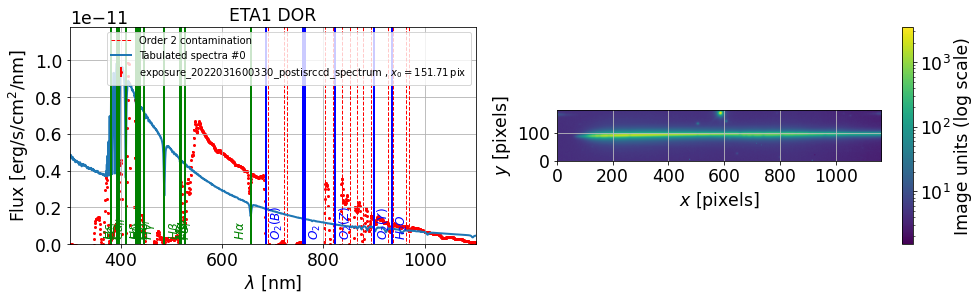

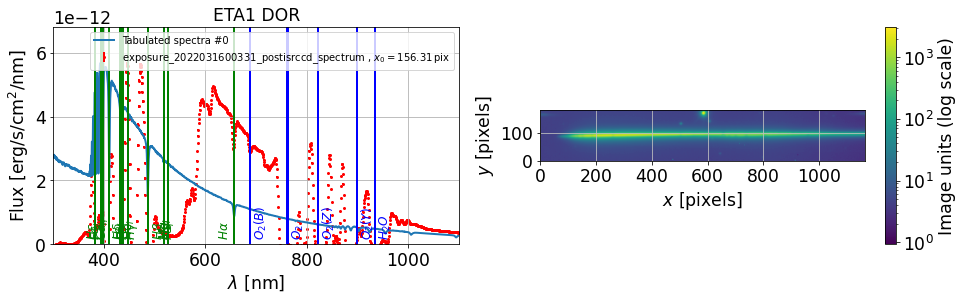

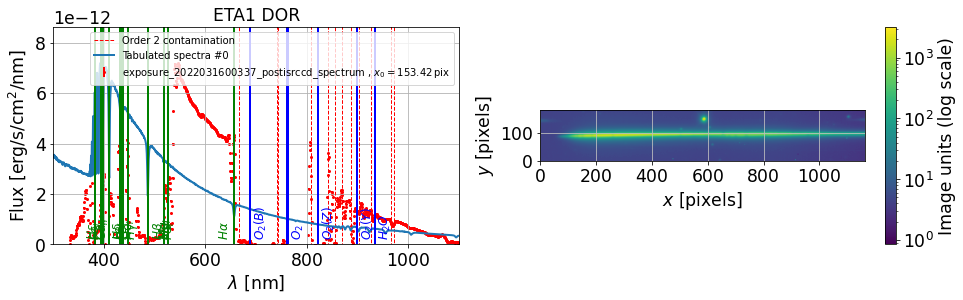

In [45]:
parameters.DISPLAY=True

infos = []
all_lambdas=[]
all_data=[]
all_num=[]

idx=0
for fullfilename in all_good_spectra_spectrum_files:
    
    filename = os.path.basename(fullfilename)
    print(idx,")",filename," ",fullfilename)
    
    
    fig=plt.figure(figsize=(16,4))
    ax1 = fig.add_subplot(1, 2, 1)
    
    filename= os.path.basename(fullfilename)
    tag=file_tag_forsorting(filename.split(".")[0])
    all_num.append(tag)
    
   
     
    s=Spectrum(fullfilename, config=config,fast_load=False)
    label=filename.split('.')[0]+" "
    s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
    all_lambdas.append(s.lambdas)
    all_data.append(s.data)
    
    ax2 = fig.add_subplot(1, 2, 2)
    
    fullfilename2=all_files_spectrogram[idx]
    
    s.load_spectrogram(fullfilename2)
    s.plot_spectrogram(ax=ax2,scale="log")
    
    
    infos.append([idx,s.date_obs,s.airmass,s.temperature,s.pressure,s.humidity])
    
    
    plt.show()
    idx+=1
    

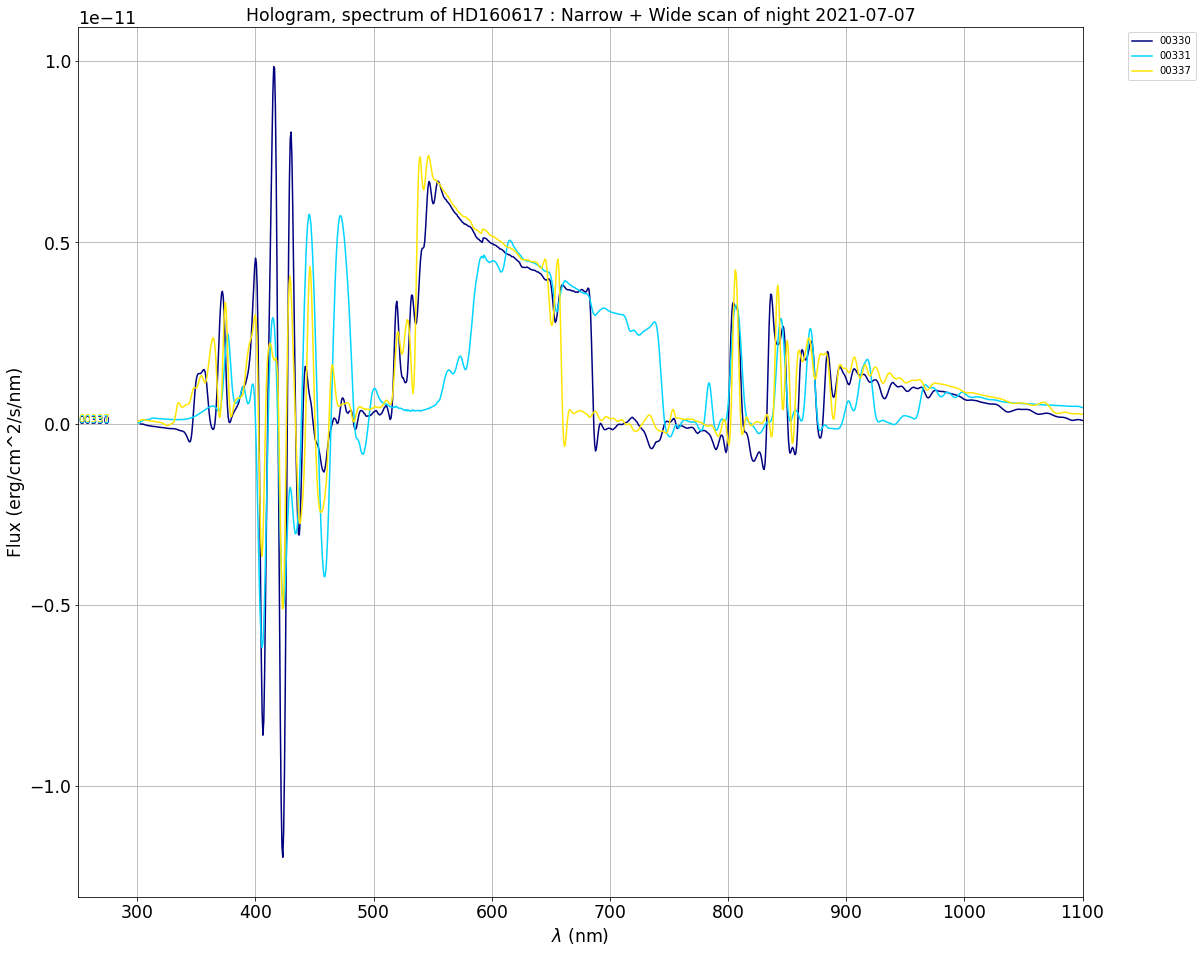

In [46]:
fig=plt.figure(figsize=(18,16))
ax=fig.add_subplot(1,1,1)

idx=0
for fullfilename in all_good_spectra_spectrum_files:
    
    filename= os.path.basename(fullfilename)
         
    #s=Spectrum(fullfilename, config=config,fast_load=False)
    label=filename.split('.')[0]+" "
    label=all_num[idx]
    
    
    
    delta=idx*1.0e-13
    #delta=0
    
    if label not in ["000284","000276","000289","000291"] :
        ax.plot(all_lambdas[idx],all_data[idx]+delta,label=label,color=all_colors[idx])
        plt.text(250.,all_data[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
    
    idx+=1
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("Flux (erg/cm^2/s/nm)")
ax.set_xlim(250.,1100)
ax.grid()
ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
ax.set_title("Hologram, spectrum of HD160617 : Narrow + Wide scan of night 2021-07-07")
plt.show()
    

# Narrow scan dataset

In [47]:
idx=0
all_num_nr = []
all_lambdas_nr = []
all_data_nr = []

for fullfilename in all_good_spectra_spectrum_files:
    
    
    if all_num[idx] >= '000317':
        all_num_nr.append(all_num[idx])
        all_lambdas_nr.append(all_lambdas[idx]) 
        all_data_nr.append(all_data[idx])
        
    idx+=1
        
    

In [48]:
def PlotSpectra(all_wl,all_spec,all_tag,delta=0, 
                thetitle="Hologram, spectrum of HD160617 : Narrow  scan of night 2021-07-07", 
                thexlabel="$\\lambda$ (nm)",theylabel="Flux (erg/cm^2/s/nm)",figsize=(14,8)):
    """
    """
    
    NN=len(all_wl)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NN)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NN), alpha=1)
    
    
    fig=plt.figure(figsize=figsize)
    ax=fig.add_subplot(1,1,1)
    
    idx=0
    for idx in range(NN):
        
        label=all_tag[idx]
        ax.plot(all_wl[idx],all_spec[idx]+delta,label=label,color=all_colors[idx])
        if delta !=0:
            plt.text(250.,all_spec[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
        
    ax.set_xlabel(thexlabel)
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title(thetitle)
    plt.show()
        
    
    

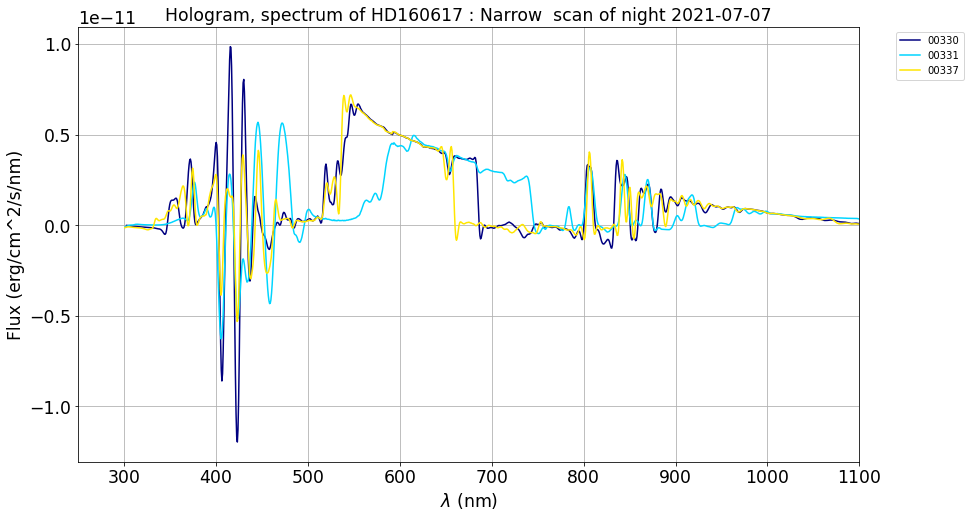

In [49]:
PlotSpectra(all_lambdas_nr,all_data_nr,all_num_nr)

In [50]:
def PlotSpectraBoth(all_wl,all_spec,all_tag,delta=0, 
                thetitle="Hologram, spectrum of HD160617 : Narrow  scan of night 2021-07-07", 
                thexlabel="$\\lambda$ (nm)",theylabel="Flux (erg/cm^2/s/nm)",figsize=(12,12)):
    """
    """
    
    NN=len(all_wl)
    
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NN)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NN), alpha=1)
    
    
    fig=plt.figure(figsize=figsize)
    
    gs = gridspec.GridSpec(2, 1,height_ratios=[1, 3] ,figure=fig)
    
    #ax=fig.add_subplot(2,1,1)
    ax=fig.add_subplot(gs[0,0])
    
    idx=0
    delta=0
    for idx in range(NN):
        
        label=all_tag[idx]
        ax.plot(all_wl[idx],all_spec[idx]+delta,label=label,color=all_colors[idx])
        if delta !=0:
            ax.plot(all_lambdas[idx],all_data[idx]+delta,label=label,color=all_colors[idx])
            plt.text(250.,all_spec[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
            
        
    #ax.set_xlabel(thexlabel)
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    #ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title("superimposed spectra")
    
    #ax=fig.add_subplot(2,1,2)
    ax=fig.add_subplot(gs[1,0])
    
    
    idx=0
    for idx in range(NN):
        
        delta=idx*0.5e-13
        
        label=all_tag[idx]
        
        if delta ==0:
            
            ax.plot(all_wl[idx],all_spec[idx]+delta,label=label,color=all_colors[idx])
            plt.text(250.,all_spec[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
        elif delta !=0:
            plt.text(250.,all_spec[idx][0]+delta, f'{label}',color=all_colors[idx],fontsize=10)
            ax.plot(all_wl[idx],all_spec[idx]+delta,label=label,color=all_colors[idx])
        
    ax.set_xlabel(thexlabel)
    ax.set_ylabel(theylabel)
    ax.set_xlim(250.,1100)
    ax.grid()
    #ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
    ax.set_title("shifted spectra")
    
    
    plt.suptitle(thetitle,y=0.95,fontsize=20,fontweight="bold")
    #plt.tight_layout()
    plt.show()
        
    
    

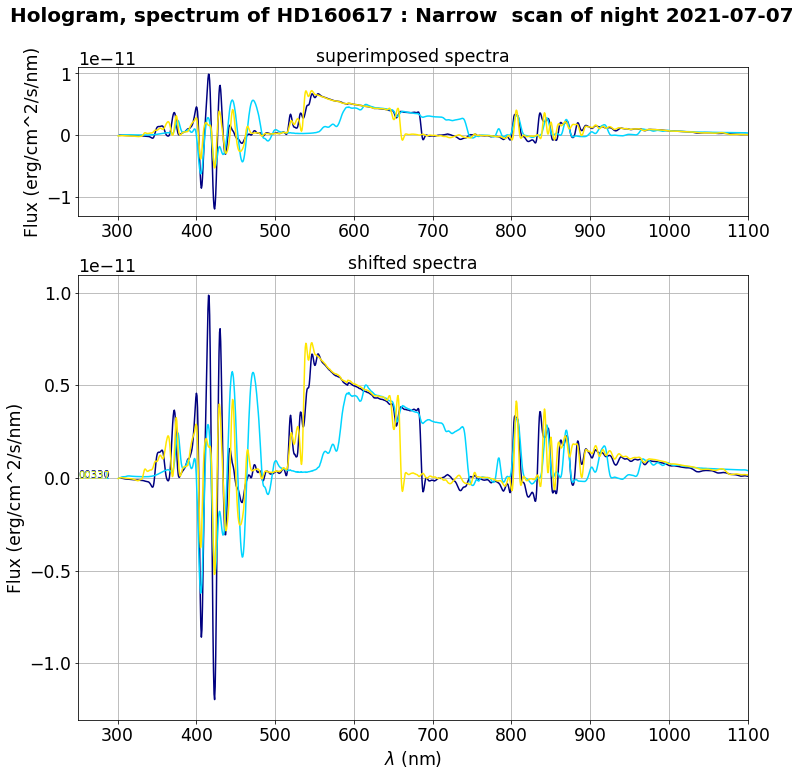

In [51]:
PlotSpectraBoth(all_lambdas_nr,all_data_nr,all_num_nr)